# Hands on Machine Learning with Scikit-Learn and Tensorflow

## Chapter 3: Classification

### Notebook by: Arunava

<hr/>
<hr/>
<hr/>

In [1]:
# Ignoring Warnings
import warnings

def warn(*args, **kwargs):
    pass
warnings.warn = warn

## MNIST
<hr/>

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist['data'], mnist['target']
print (X.shape)
print (y.shape)

(70000, 784)
(70000,)


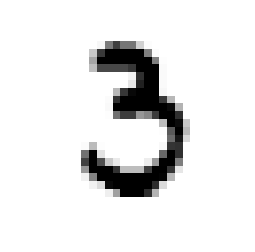

Label:  3.0


In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[23456].reshape(28, 28)
plt.imshow(some_digit, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

print ('Label: ', y[23456])

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X[shuffle_index], y[shuffle_index]

## Training a Binary Classifier
<hr/>

In [7]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3)
sgd_clf.predict(some_digit.ravel().reshape(1, -1))

array([ True])

## Performance Measures
<hr/>

Implementing cross-validation from scratch

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=42)

i = 1

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    
    X_train_f = X_train[train_index]
    y_train_f = y_train_3[train_index]
    
    X_test_f = X_train[test_index]
    y_test_f = y_train_3[test_index]
    
    clone_clf.fit(X_train_f, y_train_f)
    pred = clone_clf.predict(X_test_f)
    
    n_correct = sum(pred == y_test_f)
    acc = n_correct/len(X_test_f)
    print ('Accuracy - Iteration', i, ' :', acc)
    
    i += 1

Accuracy - Iteration 1  : 0.9619019049047548
Accuracy - Iteration 2  : 0.96565
Accuracy - Iteration 3  : 0.9648482424121206


Using `cross_val_score()` along with `sgd_clf`

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring='accuracy')

array([0.9619019 , 0.96565   , 0.96484824])

Building a dumb classifier that predicts everything in the 'not 3' class

In [11]:
from sklearn.base import BaseEstimator

class Never3Clasifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X, y=None):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_3_clf = Never3Clasifier()
cross_val_score(never_3_clf, X_train, y_train_3, cv=3, scoring='accuracy')

array([0.8976 , 0.89935, 0.8965 ])

~90% Accuaracy!

This is simply because about 10% of the classes are `3` and rest are `not_3`.

Also, if you simply predict not `3` always then you are bound to get accuracy of `90%` all the time as only `10%` of the examples are `3`.

This is the reason that `accuracy` is not a very good measure of how good a classifier really is. (Especially in cases of skewed datasets where some classes are much more frequent than others)
<hr/>

## Confusion Matrix

A general idea is to count the number of times instances of class A were classified as class B and class A i.e. correct predictions and incorrect predictions.

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
confusion_matrix(y_train_pred, y_train_3)

array([[53260,  1543],
       [  609,  4588]])

In the confusion matrix, each **row represents an actual class** while each **columnrepresents a predicted class**.

1, 1 -> true negetives

1, 2 -> false positives

2, 1 -> false negetives

2, 2 -> true positives

A perfect classifier would have only the true positives and true negetives

In [14]:
confusion_matrix(y_train_3, y_train_3)

array([[53869,     0],
       [    0,  6131]])

A more consise metric would be look at the classifier's precision which is the accuary of the positive predictions.


\begin{align}
precision = \frac{TP}{TP+FP}
\end{align}

where, _TP_ is the number of true positives and _FP_ is the number of false positives

A trivial way to have a perfect precision is to make one single positive prediction and ensure it is correct (`precision` = `1/1` = `100%`)

This would not be very useful.

So, precision is typically used along with another metric name _recall_ (sensitivity or true positive rate (TPR)) -> this is the ratio of positive instances that are correctly detected by the classifier

\begin{align}
recall = \frac{TP}{TP+FN}
\end{align}

where _FN_ is false negetives

<hr/>

### Precision and Recall

In [15]:
from sklearn.metrics import precision_score, recall_score

print ('Precision score:', precision_score(y_train_3, y_train_pred))
print ('Recall score:', recall_score(y_train_3, y_train_pred))

Precision score: 0.8828170098133539
Recall score: 0.7483281683249062


Now the 3-detector doesn't seem as good as previous.

As you can see it is correct only `82%` of the time (precision score)

and, it detects only `80%` of the `5`s

We often combine precision and recall into a single metric called the _F1 score_.

It calculates the harmonic mean which gives more weight to the low values (irrespective to regular mean where all values are treated equally)

\begin{align}
F1 = \frac{TP}{TP+\frac{FN+FP}{2}}
\end{align}

Okay, lets now compute the f1 score

In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_3, y_train_pred)

0.8100282485875706

f1 score favours classifiers that have similar precision and recall. This is not always the case as in some context you mostly care about the precision and in other contexts you care about the recall.

Increasing precision reduces recall and vice versa. This is called **precision/recall tradeoff**.

<hr/>

## Precision/Recall Tradeoff

In the SDGClassifier you cannot set the threshold directly but you can get the decision scores which is calcualted for each instance.

Raising the threshold increases the precision and decreases the recall

Lowering the threshold decreases the precision and increases the recall.

In [17]:
y_scores = sgd_clf.decision_function([some_digit.ravel()])
print ('y_scores: ', y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print ('y_some_digit_pred: ', y_some_digit_pred)

y_scores:  [150957.38355489]
y_some_digit_pred:  [ True]


Since, the threshold is set to `0` every instance is classified as `5` and thus whatever the score is the classifier would return `True`.

Let's raise the threshold.

In [18]:
threshold = 230000
y_some_digit_pred = (y_scores > threshold)
print ('y_some_digit_pred: ', y_some_digit_pred)

y_some_digit_pred:  [False]


So, how can we decide what threshold to use?

Let's get the scores of all instances using `cross_val_predict()`.

Note: Since we need to get the scores we need to pass `method='decision_function'` to `cross_val_predict()`

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method='decision_function')

With all the scores we can now calculate `precision` and `recall` for thresholds.

In [20]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

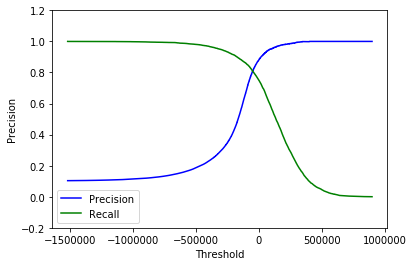

In [21]:
def plot_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b-', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.legend()
    plt.ylim([-0.2, 1.2])
    
plot_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

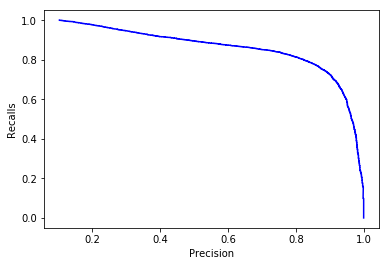

In [22]:
plt.plot(precisions, recalls, 'b-')
plt.xlabel('Precision')
plt.ylabel('Recalls')
plt.show()

If we closely look at the precison vs threshold graph and find that to get a `~90%` precision we need to use a `threshold` of `70000` then we can just simply make the predictions as the following without the use of the `predict()`.

In [23]:
y_train_90_pred = (y_scores > 70000)
print ('Precision score:', precision_score(y_train_3, y_train_90_pred))
print ('Recall score:', recall_score(y_train_3, y_train_90_pred))

Precision score: 0.9407153356197943
Recall score: 0.6263252324253792


Great! we now have a `91%` precision classifier. It's pretty easy to create a classifier with any precision.

But, it comes with a cost, look at the recall score!

## The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool with binary classifiers.

It plots the TPR (true positive rate) against the FPR (false positive rate) i.e. `sensitivity` vs `1-specificity`.

Where 

\begin{align}
TPR = sensitivity = recall
\end{align}

And,

\begin{align}
FPR = 1 - TNR
\end{align}

where

\begin{align}
FPR = false positive rate
\end{align}

\begin{align}
TNR = specificity
\end{align}

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)

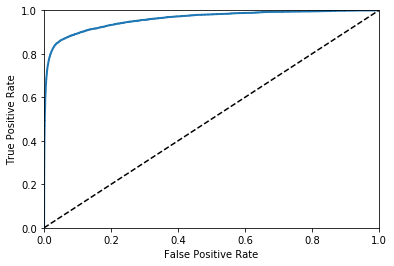

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Once again, there is a trade-off between the TPR and FPR.

One way to compare classifiers is to measure the area under the curve(AUC). A perfect classifier will have a ROC AUC equal to `1`, whereas a purely randomly classifier will have a ROC AUC equal to `0.5`.

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3, y_scores)

0.9598739627145828

As a rule of thumb, we should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negetives. And the ROC curve otherwise.

Let's train a `RandomForestClassifier` and compare its ROC curve and the ROC AUC score to the `SDGClassifier`.

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3, method='predict_proba')
y_probas_forest

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.2, 0.8]])

Since to plot ROC curve we need the scores and probabilities, a simple solution is to use the positive class's probability as the score

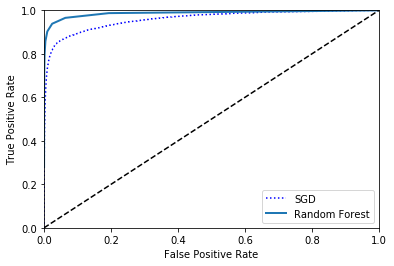

In [28]:
y_scores_forest = y_probas_forest[:, 1]
fpr_f, tpr_f, thresholds_f = roc_curve(y_train_3, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_f, tpr_f, 'Random Forest')
plt.legend(loc='bottom right')
plt.show()

We can see that `RandomForestClassifier`'s ROC curve looks much better than `SGDClassifier`'s.

And if we take a look at its roc_auc_score

In [29]:
print ('ROC AUC Score:', roc_auc_score(y_train_3, y_scores_forest))

forest_clf.fit(X_train, y_train_3)
print ('Precision Score: ', precision_score(y_train_3, forest_clf.predict(X_train)))
print ('Recall Score: ', recall_score(y_train_3, forest_clf.predict(X_train)))

ROC AUC Score: 0.9872408717258868
Precision Score:  1.0
Recall Score:  0.9879301908334692


Great!

So, now we know how to train binary classifiers:

1) Choose appropriate metric for your task

2) Evaluate your classifiers using cross validation

3) Select precision/recall tradeoff that fits the needs

4) Compare various models using ROC curves and ROC AUC scores.

Now, let's try to detect more than `5`.

## Multiclass Classification

Some algorithms are capable of handling multiple classes directly. Others are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers:

1) OvA (one-versus-all)

2) OvO (one-versus-one)

One of the advantages of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Scikit-Learn detects when we try to use a binary classifier for a multiclass classification task and it automatically runs OvA (except for SVM classifiers, which uses OvO).

Let's try this with SGDClassifier

In [30]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit.ravel()])

array([3.])

As said, under the hood, scikit learn uses OvA and trains `10` different classifiers and makes a predictions based on their decision scores.

To check this is the case, we can use the `decision_function()`

In [31]:
some_digit_scores = sgd_clf.decision_function([some_digit.ravel()])
some_digit_scores

array([[-138351.24191231, -350763.52460008, -273317.67754911,
         150957.38355489, -903511.79727288,  -91347.89672036,
        -380559.78962422, -254909.5057566 , -335632.13555252,
        -400516.91000383]])

There we have `10` different classifiers each providing a decision scores. The highest score is that of the class `5`.

In [32]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

3.0

If we want to force scikit-learn to use `one-versus-one` or `one-versus-all` you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance and pass a binary classifier to its contructor.

In [33]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit.ravel()])

array([3.])

In [34]:
len(ovo_clf.estimators_)

45

Training a RandomForestClassifier is just as easy.

In [35]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit.ravel()])

array([3.])

This time sklearn doesn't uses OvA or OvO cause RandomForestClassifier directly classify instances into multiple classes. We can use `.predict_proba()` to get the list of probabilities that the classifier assigned to each instance for each class.

In [36]:
forest_clf.predict_proba([some_digit.ravel()])

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

Let's evaluate the SGDClassifier now using `cross_val_score`

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.84998   , 0.85824291, 0.8660299 ])

It gets over 83% on all folds. Simply scaling the inputs would improve the accuracy over 90%

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=4, scoring='accuracy')

array([0.91189603, 0.90994534, 0.90885451, 0.91137046])

WooHoo! Over `90%` accuracy!

<hr/>

## Error Analysis

Let's start by looking at the confusion matrix.

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5748,    3,   23,    9,   10,   35,   45,   10,   38,    2],
       [   2, 6459,   49,   24,    6,   49,    6,   13,  121,   13],
       [  58,   33, 5357,   96,   76,   22,   93,   50,  153,   20],
       [  52,   44,  139, 5344,    3,  228,   36,   53,  135,   97],
       [  18,   28,   37,    6, 5347,   10,   56,   35,   91,  214],
       [  79,   41,   34,  185,   72, 4581,  114,   28,  184,  103],
       [  36,   24,   45,    2,   45,   86, 5632,    4,   44,    0],
       [  22,   22,   74,   26,   45,   10,    6, 5789,   17,  254],
       [  56,  163,   76,  162,   13,  163,   59,   25, 4979,  155],
       [  39,   28,   30,   87,  155,   28,    3,  193,   80, 5306]])

Let's look at an image representation of the matrix.

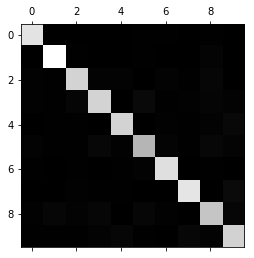

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Since most images are on the main diagonal which means that they were classified correctly. The 5s look a slightly darker which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on others.

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let's fill the diagonal with zeros to keep only the errors.

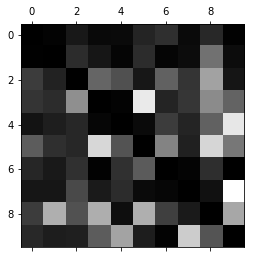

In [42]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it has errors.

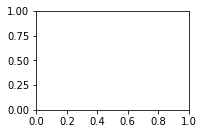

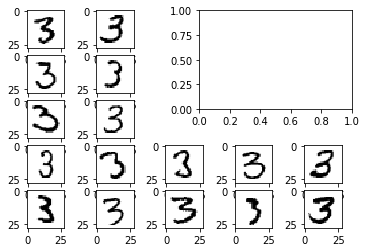

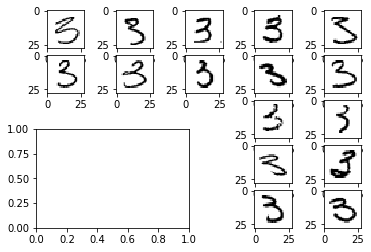

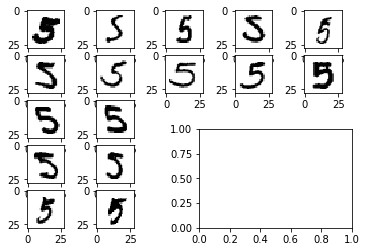

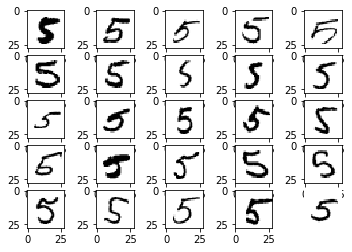

In [43]:
def plot_digits(X, img_per_row):
    '''fig, ax = plt.subplots(nrows=img_per_row, ncols=len(X)//img_per_row)
    i = 0
    for row in ax:
        for col in row:
            col.imshow(X[i].reshape(28, 28), cmap=matplotlib.cm.binary)
            i += 1
    '''
    plt.figure()
    for i in range(len(X)):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap=matplotlib.cm.binary)
    
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


plt.figure()
plt.subplot(221); plot_digits(X_aa[:25], img_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], img_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], img_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], img_per_row=5)


plt.axis('off')
plt.show()

For some of the images a human would also go wrong, for others it seems like a obvious mistake and the reason is that we used a SGDClassifier whcih is a linear model.

So, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to center the image and make sure its not too rotated.

<hr/>

## Multilabel Classification

Until now each instance has always been classified to just one class. In some cases we may want a classifier to output multiple labels for each instance. 

An example would be to output multiple binary labels (such a system is called multilabel classification system)

In [44]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

`KNeighborsClassifier` supports multilabel classification and we train it using multiple labels.

Now, let's make a perdiction.

In [45]:
knn_clf.predict([some_digit.ravel()])

array([[False,  True]])

And it gets it right!! The digit is `3` so its less than `7` indicated by the `False` and its odd indicated by `True`.

There are many ways to evaluate a multilabel classifier and selecting the right metric really depends on your project. One approach is to measure the F1 score for each label and compute the average. 

Following computes F1 score across all labels.

In [46]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
#f1_score(y_train, y_train_knn_pred)

This assumes that all labels are equally important, which may not be the case.

In case, we want to give each label a weight based on its support (the number of instances with that target label) then we can just set `average='weighted'`

## Multioutput Classification

Multioutput-multilabel classification (or simply multioutput classification) is a generalization of multilabel classification where each label can be multiclass.

To illustrate this, we will build a system that removes noise from images. So, the output will be an array of pixel intensities (multilabel) and each pixel can have multiple values (multioutput)

In [47]:
import random as rnd

noise_tr = rnd.randint(0, 100, (len(X_train), 784))
noise_tt = rnd.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_tr
X_test_mod = X_test + noise_tt
y_train_mod = X_train
y_test_mod = X_test

TypeError: randint() takes 3 positional arguments but 4 were given

Let's take a peek at an image from both the train set and test set (note this is not recommended to do as this can introduce snooping bias)

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train_mod[23].reshape(28, 28), cmap=matpltolib.cm.binary)

plt.subplot(1, 2, 2)
plt.imshow(X_test_mod[23].reshape(28, 28), cmap=matpltolib.cm.binary)

plt.show()

On the left is the noisy image and on the right is the clean target image. Now let's train the classifier and make it a clean image :)

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[23]])

plt.imshow(clean_digit.reshape(28, 28), cmap=matplotlib.cm.binary)
plt.show()

Looks close to the target :)

<hr/>

## Conclusion

And we now know how to select good metrics for classification tasks, pick the appropriate precision/recall trade off, compare classifiers and more generally build good classification systems.